In [0]:
#Hasan -> GAN model to generate MNIST dataset
import keras
from keras.datasets.mnist import load_data
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, BatchNormalization, Input, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot
import numpy as np
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [0]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
trainX.shape , trainy.shape , trainX.min(), trainX.max()

11493376/11490434 [==============================] - 2s 0us/step


((60000, 28, 28), (60000,), 0, 255)

In [0]:
#Standardize training data
trainX = trainX.astype('float32')
trainX = trainX / 255
trainX = np.expand_dims(trainX, -1)
train_dataset = trainX

trainX.shape, trainX.max()

((60000, 28, 28, 1), 1.0)

In [0]:
#Standardize training data
testX = testX.astype('float32')
testX = testX / 255
testX = np.expand_dims(testX, -1)
test_dataset = testX

testX.shape, testX.max()

((10000, 28, 28, 1), 1.0)

## Function to generate real data -> Slice from MNIST dataset

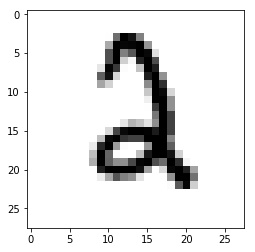

In [0]:
def generator_real_data(dataset, batch_size = 100):
  # choose random indices without replacement
	ix = np.random.choice(dataset.shape[0], batch_size, replace=False)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((batch_size, 1))
	return (X, y)

#Test generator
d = generator_real_data(train_dataset)

#plot a random output
pyplot.imshow(d[0][50, :, :, 0], cmap='gray_r')
pyplot.show()

## Function to generate fake data -> Random numbers of MNIST shape

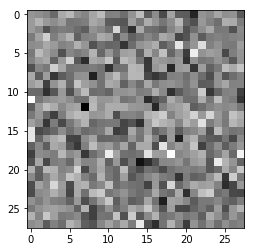

In [0]:
def generator_fake_data(dataset, batch_size = 100):
  # Create random digits of size ( image area * batch )
	rand_coll = np.random.randn(dataset.shape[1] * dataset.shape[2] * dataset.shape[3] * batch_size)
	# retrieve selected images
	X = np.reshape(rand_coll, (batch_size, dataset.shape[1], dataset.shape[2], dataset.shape[3]))
	# generate 'real' class labels (1)
	y = np.zeros((batch_size, 1))
	return (X, y)

#Test generator
d = generator_fake_data(test_dataset)

#plot a random output
pyplot.imshow(d[0][50, :, :, 0], cmap='gray_r')
pyplot.show()

In [0]:
#Generator functions to feed into KERAS training
def data_train_generator(batch_size = 100):
  while True:
    #Generate fake data
    x_fake, y_fake = generator_fake_data(train_dataset, batch_size)

    #Generate real data
    x_real, y_real = generator_real_data(train_dataset, batch_size)

    #VSTACK both datasets
    x, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
    yield( x, y )

def data_test_generator(batch_size = 100):
  while True:
    #Generate fake data
    x_fake, y_fake = generator_fake_data(test_dataset, batch_size)

    #Generate real data
    x_real, y_real = generator_real_data(test_dataset, batch_size)

    #VSTACK both datasets
    x, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
    yield( x, y )

## Discriminator model -> Model to identify FAKE Vs REAL images

1.   Input is an image of size ( 28, 28 , 1)
2.   Model gives back a sigmoid classifier output
3.   Model learns to detect real vs fake generated images

In [0]:
def compile_discriminator(v_model, trainable = True):
  opt = Adam(lr=0.0002, beta_1=0.5)
  v_model.trainable = trainable
  v_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return v_model

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 14, 14, 64)        320       
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 7, 7, 128)         32896     
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
____

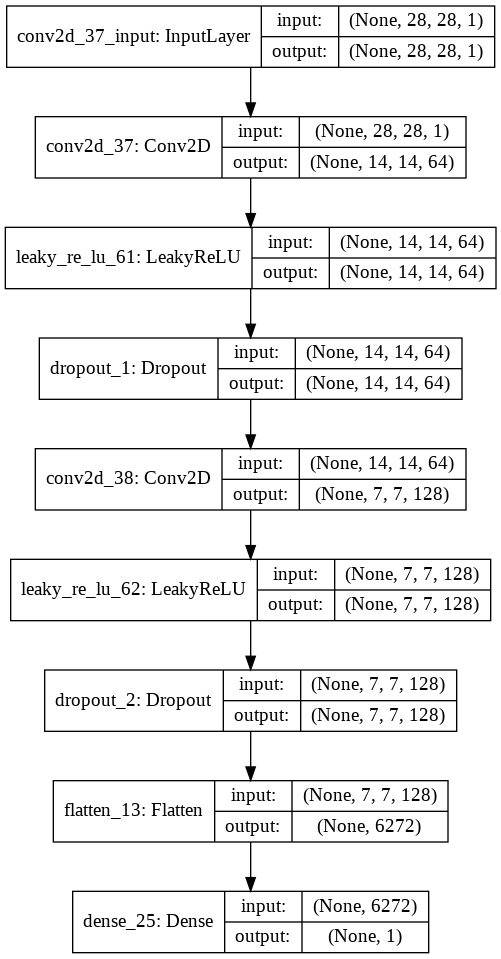

In [0]:
#Define discriminator model
def model_discriminator(summary = False):
  model = Sequential()

  #Input(batch, 28, 28, 1) -> MNIST image of (28, 28, 1)
  model.add(Conv2D(64, (2,2) , strides=(2, 2), padding = 'same', input_shape = (28,28,1)))
  model.add(LeakyReLU())
  model.add(Dropout(0.4))

  model.add(Conv2D(128, (2,2), strides=(2, 2), padding = 'same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model = compile_discriminator(model)
  
  if summary:
    model.summary()
  return model

dummy_ = model_discriminator(True)
plot_model(dummy_, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def test_discriminator_on_image(d_):
  #Real data discriminator test
  d = generator_real_data(train_dataset)
  pyplot.imshow(d[0][50, :, :, 0], cmap='gray_r')
  pyplot.show()
  print(d_.predict(d[0][50:51, :, :, :]))

  d = generator_fake_data(train_dataset)
  pyplot.imshow(d[0][50, :, :, 0], cmap='gray_r')
  pyplot.show()
  print(d_.predict(d[0][50:51, :, :, :]))

In [0]:
def test_discriminator_standalone(model):
  #Batch size = 100, total images in MNIST = 60000
  train_batch_size = 100
  test_batch_size = 100
  steps_per_epoch = 60000 / train_batch_size
  epochs = 1

  #Train and evaluate
  loss = model.fit_generator(data_train_generator(train_batch_size), steps_per_epoch = steps_per_epoch, epochs = epochs,
                          validation_data = data_test_generator(test_batch_size), validation_steps=100, validation_freq = 1)
  
  return model

#Define model and run training
m_ = test_discriminator_standalone(model_discriminator())

Epoch 1/1
600/600 [==============================] - 14s 23ms/step - loss: 0.0389 - acc: 0.9946 - val_loss: 3.0224e-04 - val_acc: 1.0000


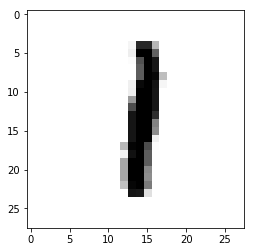

[[0.99916196]]


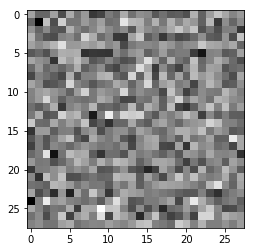

[[0.00016972]]


In [0]:
test_discriminator_on_image(m_)

## Generator model -> Model to generate FAKE images

1.   Input is a latent vector of shape ( batch , latent_dim = 100 )
2.   Latent vector is a set of randn integers
3.   Model gives an image back of size ( 28, 28 , 1)
4.   Model learns to generate images



Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 14, 14, 64)        32832     
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 28, 28, 128)       32896     
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 28, 28, 128)     

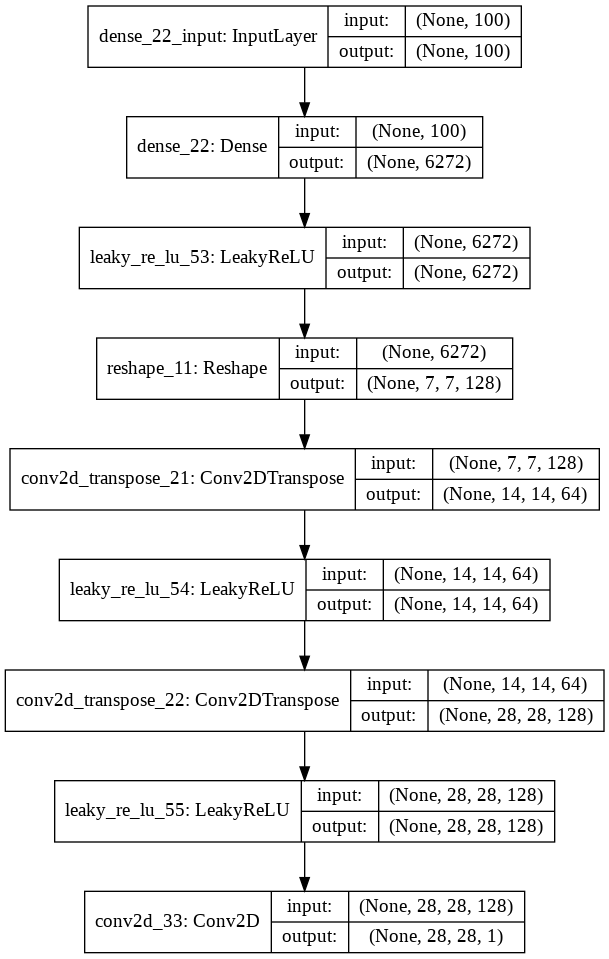

In [0]:
#Define generator model
def model_generator(summary = False, latent_dim = 100):
  model = Sequential()

  #Input(batch , latent_dim) -> latent dimension vector, connected to a dense
  model.add(Dense(128 * 7 * 7, input_dim = (latent_dim)))
  model.add(LeakyReLU())
  # model.add(BatchNormalization())
  model.add(Reshape((7, 7, 128)))  

  model.add(Conv2DTranspose(64, (2,2), strides=(2, 2), padding = 'same'))
  model.add(LeakyReLU())
  # model.add(BatchNormalization())

  model.add(Conv2DTranspose(128, (2,2), strides=(2, 2), padding = 'same'))
  model.add(LeakyReLU())
  # model.add(BatchNormalization())

  model.add(Conv2D(1, (1,1), strides=(1, 1), padding = 'same', activation='sigmoid'))

  if summary:
    model.summary()
  return model

dummy_ = model_generator(True)
plot_model(dummy_, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
#Functions to generate latent data for via generator
def generator_latent_data(latent_dim = 100, batch_size = 100):
  # Create random digits of size ( latent * batch )
  rand_coll = np.random.randn(latent_dim * batch_size)
  # retrieve selected images
  X = np.reshape(rand_coll, (batch_size, latent_dim))
  # generate 'real' class labels (1)
  y = np.ones((batch_size, 1))
  return (X, y)

def generator_yield_latent_data(latent_dim = 100, batch_size = 100):
  while True:
    X, y = generator_latent_data(latent_dim = latent_dim, batch_size = batch_size)
    yield (X, y)

(4, 1)


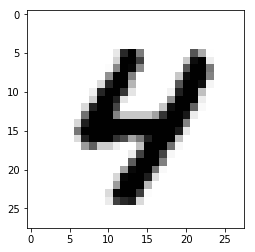

[1.]


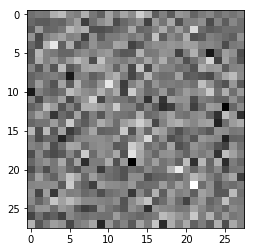

[0.]


In [0]:
#Generator model's data generation
#Real MNIST Data + Latent generated images
def create_images_for_discriminator(dataset, g_model, latent_dim, n_samples):
  while True:
    #Generate real data
    x_real, y_real = generator_real_data(dataset, batch_size = int(n_samples / 2))

    #Generator latent points
    x_input = generator_latent_data(latent_dim = latent_dim, batch_size = int(n_samples / 2))[0]

    #Generator model: Generate images from latent points
    x_fake = g_model.predict(x_input)

    ###################### Very important step ######################
    ########## Here we have to output Y( True Y ) = 0
    ########## Discriminator will learn to bifurcate Real( Y = 1 )
    ########## Vs Fake generated ( Y = 0 )

    ########## So on backprop of GAN -> Generator will learn to generate images 
    ########## which the discriminator will also fail to predict as 0( Fake )
    y_fake = np.zeros((int(n_samples / 2), 1))

    #VSTACK both datasets
    x, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))

    yield(x, y)

#test generator model
g_model = model_generator()
d = create_images_for_discriminator(train_dataset, g_model, 100, 4)
for x in d:
  #plot a random output
  print(x[1].shape)
  pyplot.imshow(x[0][0, :, :, 0], cmap='gray_r')
  pyplot.show()
  print(x[1][0])
  pyplot.imshow(x[0][-1, :, :, 0], cmap='gray_r')
  pyplot.show()
  print(x[1][-1])
  break

## GAN model -> Generator model( Freezed ) + Discriminator model

1.   Layer 1 -> Generator -> Input shape ( Batch, latent_dim )
2.   List item



In [0]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
       l.trainable = val

In [0]:
def gan_model(g_model, d_model, summary = False):
  #Copy D and G
  g_model_copy = keras.models.clone_model(g_model)
  d_model_copy = keras.models.clone_model(d_model)
  d_model_copy = compile_discriminator(d_model_copy, trainable = False)

  model = Sequential()

  #Add generator and discriminator
  model.add(g_model_copy)
  model.add(d_model_copy)

  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  # get_layer_details(model)
  
  if summary:
    model.summary()
  return model

###Test
md_ = model_discriminator()
mg_ = model_generator()

# md_.summary()
gan_ = gan_model(mg_, md_ , False)
md_.summary()
gan_.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 64)        320       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         32896     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)             

In [0]:
def copy_discriminator_weights_to_gan(gan_model, d_model):
  #Get source generator's weights
  src_weights = d_model.get_weights()
  # print(src_weights.shape)

  #Recalibrate gan's generator layer
  gan_model.layers[1].set_weights(src_weights)

  return gan_model

x = copy_discriminator_weights_to_gan(gan_, md_)
x.summary()
md_.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 28, 28, 1)         699329    
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 40257     
Total params: 739,586
Trainable params: 699,329
Non-trainable params: 40,257
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 64)        320       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_____________________

In [0]:
def copy_gan_weights_to_generator(gan_model, g_model):
  #Get GAN's generator's weights
  src_weights = gan_model.layers[0].get_weights()

  # print(src_weights.shape)
  #Recalibrate gan's generator layer
  g_model.set_weights(src_weights)

  return g_model

x = copy_gan_weights_to_generator(gan_, mg_)
x.summary()
gan_.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 64)        32832     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 128)       32896     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 28, 28, 128)      

Epoch 1/1
600/600 [==============================] - 16s 27ms/step - loss: 0.0029 - acc: 0.9994 - val_loss: 3.5346e-05 - val_acc: 1.0000


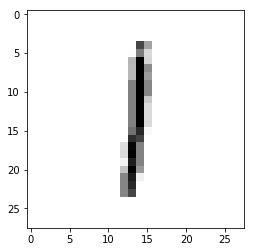

[[0.99999905]]


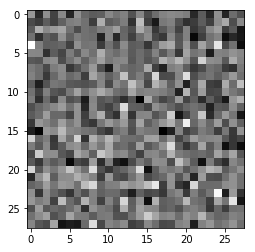

[[4.886715e-05]]


In [0]:
#Method to test discriminator model's accuracy on generator's generated data
def test_discriminator_on_generator_pred(dataset, vg_model, d_model, latent_dim = 100):
  for i_ in create_images_for_discriminator(dataset, vg_model, latent_dim, 100):
    #Generate images from latent points as input
    # x_fake = _g.predict(i_[0])

    pyplot.imshow(i_[0][0, :, :, 0], cmap='gray_r')
    pyplot.show()

    #Prediction from Discriminator model
    print(d_model.predict(i_[0][0:1, :, :, :]))

    pyplot.imshow(i_[0][-1, :, :, 0], cmap='gray_r')
    pyplot.show()

    #Prediction from Discriminator model
    print(d_model.predict(i_[0][-1:, :, :, :]))  
    break

##Test model
_d_model = model_discriminator()
_g_model = model_generator()
_gan_model = gan_model(_g_model, _d_model)

#Train discriminator
_d_model.fit_generator(create_images_for_discriminator(train_dataset, _g_model, 100, 100), 
                        steps_per_epoch = 600, 
                        epochs = 1, 
                        validation_data = create_images_for_discriminator(test_dataset, _g_model, 100, 100), 
                        validation_steps=100, validation_freq = 1, 
                        workers=0)

test_discriminator_on_generator_pred(test_dataset, _g_model, _d_model)

In [0]:
# train the generator and discriminator
def train_gan(vg_model, vd_model, vgan_model, n_batch=200, epochs = 1, summary = False, latent_dim = 100):
  train_batch_size = n_batch
  test_batch_size = n_batch
  steps_per_epoch = 60000 / train_batch_size
  bats_per_epoch = 60000 / (n_batch * steps_per_epoch)
  latent_dim = latent_dim

  for i in range(3): #range(epochs * int(bats_per_epoch)):
    print("Fitting Discriminator ....")
    if summary:
      vd_model.summary()

    # #Copy GAN's weights to generator model -> So that discriminator learns to
    # #discriminate generator's predictions
    # vg_model = copy_gan_weights_to_generator(vgan_model, vg_model)
    
    #Train discriminator
    vd_model.fit_generator(create_images_for_discriminator(train_dataset, vg_model, latent_dim, train_batch_size * 2), 
                          steps_per_epoch = steps_per_epoch, 
                          epochs = 1, 
                          validation_data = create_images_for_discriminator(test_dataset, vg_model, latent_dim, test_batch_size), 
                          validation_steps=100, validation_freq = 1, workers=0)
    
    # vd_model.evaluate_generator(create_images_for_discriminator(test_dataset, vg_model, latent_dim, test_batch_size), 
    #                       steps = 1)
    
    #Predict on output from trained VG 
    if summary:
      test_discriminator_on_generator_pred(test_dataset, vg_model, vd_model)

    ###################### Very important step ######################
    ########## On backprop of GAN -> Generator will learn to generate images 
    ########## such that discriminator predicts them as 1( Predicted Y - Real )
    ########## Discriminator is already FROZEN, hence 
    ########## Generator is FORCED to generate real looking images

    #Copy Discriminator weights to GAN's discriminator model
    vgan_model = copy_discriminator_weights_to_gan(vgan_model, vd_model)

    print("Fitting GAN( Generator's train )....")
    if summary:
      vgan_model.summary()      

    #Train GAN's embedded generator model as Discriminator is frozen
    vgan_model.fit_generator(generator_yield_latent_data(latent_dim = latent_dim, batch_size = train_batch_size * 2), 
                          steps_per_epoch = steps_per_epoch, 
                          epochs = 1,
                          validation_data = generator_yield_latent_data(latent_dim = latent_dim, batch_size = test_batch_size), 
                          validation_steps=300, validation_freq = 1, workers=0)
    
    # vgan_model.evaluate_generator(generator_yield_latent_data(latent_dim = latent_dim, batch_size = train_batch_size), 
    #                       steps = 1)
    
    #Copy GAN's weights to generator model -> So that discriminator learns to
    #discriminate generator's predictions
    vg_model = copy_gan_weights_to_generator(vgan_model, vg_model)
    
    #Predict on output from trained VG
    if summary:
      test_discriminator_on_generator_pred(test_dataset, vg_model, vd_model)

    if summary:
      vd_model.summary()
    
  return vg_model, vd_model , vgan_model

In [0]:
#### Run GAN training process
latent_dim = 100
_d_model = model_discriminator()
_g_model = model_generator(latent_dim = latent_dim)
_gan_model = gan_model(_g_model, _d_model)

_g, _d, _gan = train_gan(_g_model, _d_model, _gan_model, summary = False, latent_dim = latent_dim)

Fitting Discriminator ....
Epoch 1/1
300/300 [==============================] - 22s 75ms/step - loss: 0.0726 - acc: 0.9784 - val_loss: 6.8331e-04 - val_acc: 1.0000
Fitting GAN( Generator's train )....
Epoch 1/1
300/300 [==============================] - 34s 114ms/step - loss: 0.8682 - acc: 0.8469 - val_loss: 0.0036 - val_acc: 1.0000
Fitting Discriminator ....
Epoch 1/1
300/300 [==============================] - 17s 56ms/step - loss: 0.0620 - acc: 0.9913 - val_loss: 0.0040 - val_acc: 1.0000
Fitting GAN( Generator's train )....
Epoch 1/1
300/300 [==============================] - 29s 98ms/step - loss: 0.0392 - acc: 0.9926 - val_loss: 0.0026 - val_acc: 1.0000
Fitting Discriminator ....
Epoch 1/1
300/300 [==============================] - 16s 55ms/step - loss: 0.1420 - acc: 0.9682 - val_loss: 0.0170 - val_acc: 0.9990
Fitting GAN( Generator's train )....
Epoch 1/1
300/300 [==============================] - 29s 98ms/step - loss: 0.0524 - acc: 0.9857 - val_loss: 0.0011 - val_acc: 1.0000


Discriminator


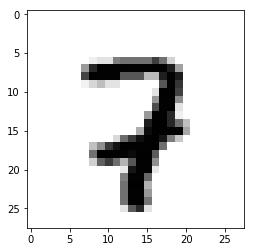

[[0.99593145]]


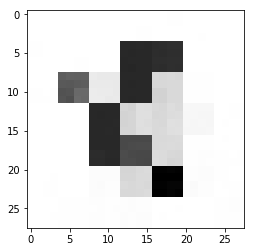

[[0.99956554]]
Generator


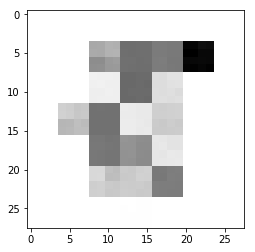

[[0.99991584]]


In [0]:
#Test discriminator model
latent_dim = 100
print("Discriminator")
test_discriminator_on_generator_pred(test_dataset, _g, _d, latent_dim = latent_dim)

#Generator model: Latent input to image 
print("Generator")
for x in generator_yield_latent_data(latent_dim = latent_dim, batch_size = 1):
  lp = x[0]
  lpoint = lp
  break

generated_img = _g.predict(lpoint)
pyplot.imshow(generated_img[0,:,:,0], cmap='gray_r')
pyplot.show()

#VGAN model: Latent input to classification
# g_[0:1, :]
print(_gan.predict(lpoint))